<a href="https://colab.research.google.com/github/shayan-fallah/Vgg16/blob/main/PatchWavlet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d divg07/casia-20-image-tampering-detection-dataset -p /content/gdrive/MyDrive/CASIA2_with_mask/ --unzip


Dataset URL: https://www.kaggle.com/datasets/divg07/casia-20-image-tampering-detection-dataset
License(s): unknown
 99% 2.53G/2.56G [00:16<00:00, 140MB/s] 
100% 2.56G/2.56G [00:16<00:00, 167MB/s]


In [ ]:
    %xterm

UsageError: Line magic function `%xterm` not found.


In [ ]:
!pip install tensorflow


## STEP 1 : Prepare the dataset
#What do we need?

    - A collection of images with ground-truth masks indicating which patches are forged vs. authentic.

    - We will split each image into overlapping 32×32 patches.

    - For each patch, extract wavelet features (details later).

    - Label patches as forged/authentic based on mask coverage.

# STEP 1 (ALL data)

In [ ]:
import os
import numpy as np
from skimage.io import imread
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

patch_size = 32
stride = 16
forged_threshold = 0.1  # 10% forged pixels to label patch forged

def ensure_three_channels(patch):
    # If patch is grayscale (2D), convert to 3-channel by repeating dims
    if patch.ndim == 2:
        patch = np.stack([patch]*3, axis=-1)
    # If patch has alpha channel (4 channels), drop the last channel
    if patch.shape[-1] == 4:
        patch = patch[..., :3]
    return patch

def extract_patches_and_labels(image, mask=None, patch_size=32, stride=16, forged_threshold=0.1):
    """
    Extract patches from image and, if mask is provided, assign labels based on mask.
    If mask is None, label all patches authentic (0).
    """
    patches = []
    labels = []
    H, W = image.shape[:2]
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch_img = image[y:y+patch_size, x:x+patch_size]
            patch_img = ensure_three_channels(patch_img)
            if mask is not None:
                patch_mask = mask[y:y+patch_size, x:x+patch_size]
                forged_frac = np.mean(patch_mask)
                label = 1 if forged_frac >= forged_threshold else 0
            else:
                label = 0  # All authentic if no mask
            patches.append(patch_img)
            labels.append(label)
    return patches, labels

# Paths
au_path = '/content/gdrive/My Drive/CASIA2_with_mask/CASIA2/Au'
tp_path = '/content/gdrive/My Drive/CASIA2_with_mask/CASIA2/Tp'
mask_path = '/content/gdrive/MyDrive/CASIA2_with_mask/CASIA2/CASIA 2 Groundtruth'

all_patches = []
all_labels = []

# Process Tp (tampered) images with masks
for dirname, _, filenames in os.walk(tp_path):
    for filename in filenames:
        if filename.lower().endswith(('jpg', 'png', 'tif')):
            img_path = os.path.join(dirname, filename)
            mask_file = os.path.splitext(filename)[0] + '_gt.png'  # mask assumed to be png
            print(mask_file)
            mask_file_path = os.path.join(mask_path, mask_file)

            if not os.path.exists(mask_file_path):
                print(f"Warning: mask not found for {filename}, skipping")
                continue

            img = imread(img_path).astype(np.float32) / 255.0
            mask = imread(mask_file_path)
            # Convert mask to binary if needed
            if mask.ndim == 3:
                mask = mask[..., 0] > 128
            else:
                mask = mask > 128

            patches, labels = extract_patches_and_labels(img, mask=mask, patch_size=patch_size, stride=stride, forged_threshold=forged_threshold)

            all_patches.extend(patches)
            all_labels.extend(labels)

# Process Au (authentic) images — all patches authentic
for dirname, _, filenames in os.walk(au_path):
    for filename in filenames:
        if filename.lower().endswith(('jpg', 'png', 'tif')):
            img_path = os.path.join(dirname, filename)
            img = imread(img_path).astype(np.float32) / 255.0
            patches, labels = extract_patches_and_labels(img, mask=None, patch_size=patch_size, stride=stride)
            all_patches.extend(patches)
            all_labels.extend(labels)



print(f"Total patches extracted: {len(all_patches)}")

# Convert to numpy arrays
X_patches = np.array(all_patches)
Y_patches = np.array(all_labels)

# Shuffle and convert labels to one-hot
X_patches, Y_patches = shuffle(X_patches, Y_patches, random_state=42)
Y_patches_cat = to_categorical(Y_patches, 2)

# Split train/validation
X_train, X_val, Y_train, Y_val = train_test_split(X_patches, Y_patches_cat, test_size=0.2, random_state=42)

print(f"Training patches: {len(X_train)}, Validation patches: {len(X_val)}")


# STEP 1 (Slice of data)

In [2]:
max_images = 500 # Limit to 100 images per category
max_images_au = 160
import os
import numpy as np
from skimage.io import imread
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

patch_size = 32
stride = 16
forged_threshold = 0.08 # 10% forged pixels to label patch forged

def ensure_three_channels(patch):
    # If patch is grayscale (2D), convert to 3-channel by repeating dims
    if patch.ndim == 2:
        patch = np.stack([patch]*3, axis=-1)
    # If patch has alpha channel (4 channels), drop the last channel
    if patch.shape[-1] == 4:
        patch = patch[..., :3]
    return patch

def extract_patches_and_labels(image, mask=None, patch_size=32, stride=16, forged_threshold=0.1):
    """
    Extract patches from image and, if mask is provided, assign labels based on mask.
    If mask is None, label all patches authentic (0).
    """
    patches = []
    labels = []
    H, W = image.shape[:2]
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch_img = image[y:y+patch_size, x:x+patch_size]
            patch_img = ensure_three_channels(patch_img)
            if mask is not None:
                patch_mask = mask[y:y+patch_size, x:x+patch_size]
                forged_frac = np.mean(patch_mask)
                label = 1 if forged_frac >= forged_threshold else 0
            else:
                label = 0  # All authentic if no mask
            patches.append(patch_img)
            labels.append(label)
    return patches, labels

# Paths
au_path = '/content/gdrive/My Drive/CASIA2_with_mask/CASIA2/Au'
tp_path = '/content/gdrive/My Drive/CASIA2_with_mask/CASIA2/Tp'
mask_path = '/content/gdrive/MyDrive/CASIA2_with_mask/CASIA2/CASIA 2 Groundtruth'

all_patches = []
all_labels = []
# Process Tp (tampered) images with masks - limit to 100 images
tp_count = 0
tp_progress = tqdm(total=max_images, desc="Processing Tp images")
for dirname, _, filenames in os.walk(tp_path):
    for filename in filenames:
        if filename.lower().endswith(('jpg', 'png', 'tif')):
            if tp_count >= max_images:
                break  # stop after 100 images

            img_path = os.path.join(dirname, filename)
            mask_file = os.path.splitext(filename)[0] + '_gt.png'  # mask assumed to be png
            mask_file_path = os.path.join(mask_path, mask_file)

            if not os.path.exists(mask_file_path):
                print(f"Warning: mask not found for {filename}, skipping")
                continue

            img = imread(img_path).astype(np.float32) / 255.0
            mask = imread(mask_file_path)
            # Convert mask to binary if needed
            if mask.ndim == 3:
                mask = mask[..., 0] > 128
            else:
                mask = mask > 128

            patches, labels = extract_patches_and_labels(img, mask=mask, patch_size=patch_size, stride=stride, forged_threshold=forged_threshold)

            all_patches.extend(patches)
            all_labels.extend(labels)

            tp_count += 1
            tp_progress.update(1)
    if tp_count >= max_images:
        break  # stop outer loop too
tp_progress.close()
# Process Au (authentic) images — all patches authentic, limit to 100 images
au_count = 0
# au_progress = tqdm(total=max_images_au, desc="Processing Au images")
# for dirname, _, filenames in os.walk(au_path):
#     for filename in filenames:
#         if filename.lower().endswith(('jpg', 'png', 'tif')):
#             if au_count >= max_images_au:
#                 break  # stop after 100 images

#             img_path = os.path.join(dirname, filename)
#             img = imread(img_path).astype(np.float32) / 255.0
#             print(au_count)
#             patches, labels = extract_patches_and_labels(img, mask=None, patch_size=patch_size, stride=stride)
#             all_patches.extend(patches)
#             all_labels.extend(labels)

#             au_count += 1
#             au_progress.update(1)
#     if au_count >= max_images_au:
#         break  # stop outer loop too

# au_progress.close()
X_patches = np.array(all_patches)
Y_patches = np.array(all_labels)

# Shuffle and convert labels to one-hot
X_patches, Y_patches = shuffle(X_patches, Y_patches, random_state=42)
Y_patches_cat = to_categorical(Y_patches, 2)

# Split train/validation
X_train, X_val, Y_train, Y_val = train_test_split(X_patches, Y_patches_cat, test_size=0.2, random_state=42)

print(f"Training patches: {len(X_train)}, Validation patches: {len(X_val)}")

Processing Tp images:   5%|▌         | 27/500 [01:02<11:39,  1.48s/it]

Processing Tp images:   7%|▋         | 36/500 [01:22<23:35,  3.05s/it]

Processing Tp images:   8%|▊         | 38/500 [02:17<1:40:11, 13.01s/it]

Processing Tp images:  29%|██▉       | 144/500 [03:36<04:00,  1.48it/s]

Processing Tp images:  31%|███       | 156/500 [03:45<04:58,  1.15it/s]

Processing Tp images:  70%|██████▉   | 349/500 [06:25<01:57,  1.29it/s]

Processing Tp images:  71%|███████   | 353/500 [06:31<03:06,  1.27s/it]

Processing Tp images:  72%|███████▏  | 362/500 [06:38<01:41,  1.36it/s]

Processing Tp images:  74%|███████▍  | 369/500 [06:43<01:24,  1.55it/s]

Processing Tp images:  76%|███████▌  | 380/500 [06:53<01:44,  1.15it/s]

Processing Tp images: 100%|██████████| 500/500 [08:30<00:00,  1.02s/it]


Training patches: 261977, Validation patches: 65495


## STEP 2 : Wavelet Feature Extraction for Patch Dataset

In [11]:
import pywt
import numpy as np
from skimage.color import rgb2ycbcr
from tqdm import tqdm  # for progress bar, optional

def extract_wavelet_features(patch, wavelet='db2', level=1):
    """
    Extract wavelet features from a single image patch.

    Args:
        patch: numpy array (H, W, 3), RGB values normalized [0,1]
        wavelet: wavelet type (default 'db2')
        level: decomposition level

    Returns:
        feature_vector: 1D numpy array of concatenated wavelet coefficients
    """
    # Convert RGB to YCbCr color space
    ycbcr_patch = rgb2ycbcr(patch)

    features = []
    for ch in range(3):
        channel_data = ycbcr_patch[:, :, ch]
        # 2D wavelet decomposition
        coeffs = pywt.wavedec2(channel_data, wavelet=wavelet, level=level)
        # coeffs structure: (cA_n, (cH_n, cV_n, cD_n), ..., (cH_1, cV_1, cD_1))

        # Flatten approximation coefficients (lowest freq)
        cA = coeffs[0].flatten()
        features.append(cA)

        # Flatten detail coefficients for each level (horizontal, vertical, diagonal)
        for detail_level in coeffs[1:]:
            for arr in detail_level:
                features.append(arr.flatten())

    # Concatenate all coefficients into a single vector
    feature_vector = np.concatenate(features)
    return feature_vector

# Assume X_train and X_val are numpy arrays of shape (N, 32, 32, 3)
# with pixel values normalized between 0 and 1.

def extract_features_for_dataset(X):
    features = []
    for patch in tqdm(X, desc="Extracting wavelet features"):
        feat = extract_wavelet_features(patch)
        features.append(feat)
    return np.array(features)

# Extract features for training set
X_train_features = extract_features_for_dataset(X_train)
print(f"Training features shape: {X_train_features.shape}")

# Extract features for validation set
X_val_features = extract_features_for_dataset(X_val)
print(f"Validation features shape: {X_val_features.shape}")


Extracting wavelet features: 100%|██████████| 261977/261977 [01:40<00:00, 2610.49it/s]


Training features shape: (261977, 3468)


Extracting wavelet features: 100%|██████████| 65495/65495 [00:24<00:00, 2706.22it/s]


Validation features shape: (65495, 3468)


### PCA 3468 --> 512

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=512, random_state=42)
X_train_pca = pca.fit_transform(X_train_features)
X_val_pca = pca.transform(X_val_features)

print(f"PCA reduced training features shape: {X_train_pca.shape}")

PCA reduced training features shape: (261977, 512)


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_dim = X_train_features.shape[1]  # feature vector length

# Build SAE model
input_layer = layers.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(512, activation='relu')(input_layer)
encoded = layers.Dense(256, activation='relu')(encoded)
encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)  # latent space

# Decoder
decoded = layers.Dense(128, activation='relu')(encoded)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)  # reconstruct original features

# SAE model (input -> reconstruction)
autoencoder = models.Model(input_layer, decoded)

# Encoder model (input -> compressed features)
encoder = models.Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3468)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │     1,776,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3468)           │     1,779,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,900,620 (14.88 MB)

 Trainable params: 3,900,620 (14.88 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_deep_sae(input_dim):
    input_layer = layers.Input(shape=(input_dim,))

    # Encoder - gradual compression
    x = layers.Dense(2048, activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    latent = layers.Dense(128, activation='relu')(x)  # Latent space

    # Decoder - mirror encoder
    x = layers.Dense(256, activation='relu')(latent)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(2048, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    output_layer = layers.Dense(input_dim, activation='linear')(x)

    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    encoder = models.Model(inputs=input_layer, outputs=latent)

    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder

# Example usage
input_dim = X_train_features.shape[1]  # feature vector length
autoencoder, encoder = build_deep_sae(input_dim)
autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3801)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2048)           │     7,786,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 1024)           │         4,09

 Total params: 21,181,785 (80.80 MB)

 Trainable params: 21,166,425 (80.74 MB)

 Non-trainable params: 15,360 (60.00 KB)

In [15]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(
    X_train_features, X_train_features,
    epochs=30,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val_features, X_val_features),
    callbacks=[early_stopping]
)


Epoch 1/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - loss: 1012.4515 - val_loss: 255.7410
Epoch 2/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 236.7433 - val_loss: 199.9639
Epoch 3/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 200.2327 - val_loss: 176.3550
Epoch 4/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 231.5311 - val_loss: 225.1540
Epoch 5/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 206.3509 - val_loss: 185.3367
Epoch 6/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 182.0655 - val_loss: 173.0247
Epoch 7/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 172.1048 - val_loss: 167.5188
Epoch 8/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 169.2905 - val_loss: 164.7672
Epoch 9/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 165.6143 - val_loss: 169.8441
Epoch 10/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 162.0193 - val_loss: 156.8492
Epoch 11/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 159.7306 - va

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_features_scaled = scaler.fit_transform(X_train_features)
X_val_features_scaled = scaler.transform(X_val_features)

history = autoencoder.fit(
    X_train_features_scaled, X_train_features_scaled,
    epochs=50,
    batch_size=256,
    validation_data=(X_val_features_scaled, X_val_features_scaled)
)



# STEP 4 : MLP

In [19]:
from tensorflow.keras import layers, models

# input_dim = encoder_output_dim = 64  # match SAE bottleneck size

mlp_input = layers.Input(shape=(input_dim,))

x = layers.Dense(128, activation='relu')(mlp_input)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(2, activation='softmax')(x)

mlp_model = models.Model(inputs=mlp_input, outputs=output)

mlp_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mlp_model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,706 (65.26 KB)

 Trainable params: 16,706 (65.26 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compute class weights based on the distribution in your training labels
y_train_labels = np.argmax(Y_train, axis=1)  # Convert one-hot to integer labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))
history = mlp_model.fit(
    encoder.predict(X_train_features),  # compressed features from SAE encoder
    Y_train,
    epochs=30,
    batch_size=256,
    validation_data=(encoder.predict(X_val_features), Y_val),
    shuffle=True,
    class_weight=class_weights_dict,  # Apply class weights here
)


8187/8187 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Epoch 1/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9124 - loss: 0.9055 - val_accuracy: 0.9319 - val_loss: 0.6437
Epoch 2/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8651 - loss: 0.6910 - val_accuracy: 0.9319 - val_loss: 0.6887
Epoch 3/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7767 - loss: 0.6919 - val_accuracy: 0.7069 - val_loss: 0.6754
Epoch 4/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5450 - loss: 0.6852 - val_accuracy: 0.4769 - val_loss: 0.6660
Epoch 5/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5636 - loss: 0.6815 - val_accuracy: 0.5328 - val_loss: 0.6584
Epoch 6/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4772 - loss: 0.6808 - val_accuracy: 0.3579 - val_loss: 0.6774
Epoch 7/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3472 - loss: 0.6855 - val_accuracy: 0.2958 - val_loss: 0.6873
Epo

In [ ]:
print(len(X_train_features))
print(len(Y_train))

261977
261977


## with class weight

In [ ]:
from sklearn.utils import class_weight

# Compute class weights based on the distribution in your training labels
y_train_labels = np.argmax(Y_train, axis=1)  # Convert one-hot to integer labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

# Train the model with class weights
history = mlp_model.fit(
    encoder.predict(X_train_features),
    Y_train,
    epochs=30,
    batch_size=256,
    validation_data=(encoder.predict(X_val_features), Y_val),
    shuffle=True,
    class_weight=class_weights_dict  # Apply class weights here
)


## More vebused training

In [18]:
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Assume input_dim is 64 (the latent size from the SAE encoder)
input_dim = 64

# MLP Model Definition (same as before, but we'll add batch normalization)
mlp_input = layers.Input(shape=(input_dim,))

# First dense block
x = layers.Dense(512, activation='relu')(mlp_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

# Second dense block
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

# Third dense block
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Fourth dense block
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Fifth dense block
x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)

# Output layer
output = layers.Dense(2, activation='softmax')(x)  # 2 classes: Authentic / Forged
mlp_model = models.Model(inputs=mlp_input, outputs=output)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for better optimization
mlp_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mlp_model.summary()

# Compute class weights based on the distribution in your training labels
y_train_labels = np.argmax(Y_train, axis=1)  # Convert one-hot to integer labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with class weights and early stopping
history = mlp_model.fit(
    encoder.predict(X_train_features),  # Use encoded features from SAE
    Y_train,                             # One-hot encoded labels (authentic/forged)
    epochs=30,
    batch_size=256,
    validation_data=(encoder.predict(X_val_features), Y_val),  # Validation set
    shuffle=True,
    class_weight=class_weights_dict,  # Apply class weights here
    callbacks=[early_stopping]        # Apply early stopping
)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,874 (827.63 KB)

 Trainable params: 209,890 (819.88 KB)

 Non-trainable params: 1,984 (7.75 KB)

Class weights: {0: np.float64(0.5360889085335658), 1: np.float64(7.427336130641869)}
8187/8187 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
2047/2047 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Epoch 1/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.4917 - loss: 0.9991 - val_accuracy: 0.5872 - val_loss: 0.6376
Epoch 2/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5186 - loss: 0.7745 - val_accuracy: 0.5922 - val_loss: 0.6238
Epoch 3/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5093 - loss: 0.7374 - val_accuracy: 0.6021 - val_loss: 0.6235
Epoch 4/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5111 - loss: 0.7087 - val_accuracy: 0.6104 - val_loss: 0.6253
Epoch 5/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5132 - loss: 0.6903 - val_accuracy: 0.5826 - val_loss: 0.6372
Epoch 6/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5088 - loss: 0.6805 - val_accuracy: 0.6060 - val_loss: 0.6218
Epoch 7/30
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 3s 3m

KeyboardInterrupt: 

## Raw WaveLet input

In [ ]:
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Assume input_dim is 64 (the latent size from the SAE encoder)
# input_dim = 64
input_dim = X_train_features.shape[1]  # feature vector length

# MLP Model Definition (same as before, but we'll add batch normalization)
mlp_input = layers.Input(shape=(input_dim,))

x = layers.Dense(256, activation='relu')(mlp_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(2, activation='softmax')(x)  # 2 output classes (Authentic / Forged)

mlp_model = models.Model(inputs=mlp_input, outputs=output)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for better optimization
mlp_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mlp_model.summary()

# Compute class weights based on the distribution in your training labels
y_train_labels = np.argmax(Y_train, axis=1)  # Convert one-hot to integer labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with class weights and early stopping
history = mlp_model.fit(
    # encoder.predict(X_train_features),  # Use encoded features from SAE
    X_train_features,
    Y_train,                             # One-hot encoded labels (authentic/forged)
    epochs=30,
    batch_size=256,
    # validation_data=(encoder.predict(X_val_features), Y_val),  # Validation set
    validation_data=(X_val_features, Y_val),  # Validation set
    shuffle=True,
    class_weight=class_weights_dict,  # Apply class weights here
    callbacks=[early_stopping]        # Apply early stopping
)


# Testing

In [ ]:
import numpy as np
from skimage.io import imread
from skimage.color import gray2rgb
import matplotlib.pyplot as plt

patch_size = 32
stride = 16

def extract_patches(image, patch_size=32, stride=16):
    patches = []
    positions = []
    H, W = image.shape[:2]
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patches.append(patch)
            positions.append((y, x))
    return patches, positions

# 1. Load and preprocess
img_path = '/content/gdrive/My Drive/CASIA2_with_mask/CASIA2/Au/Au_ani_00014.jpg'
img = imread(img_path)
if img.ndim == 2:
    img = gray2rgb(img)  # convert grayscale to 3-channel
if img.shape[-1] == 4:
    img = img[..., :3]   # drop alpha channel if exists
img = img.astype(np.float32) / 255.0

# 2. Extract patches
patches, positions = extract_patches(img, patch_size, stride)
print(f"patches: {patches[:1]}")

# 3. Extract wavelet features
features = np.array([extract_wavelet_features(p) for p in patches])
print(f"features: {features[:5]}")

# 4. Encode with SAE encoder
compressed_feats = encoder.predict(features)
print(f"compressed_feats: {compressed_feats[:5]}")

# 5. Classify patches with MLP
pred_probs = mlp_model.predict(compressed_feats)
forged_probs = pred_probs[:, 1]  # probability of "forged" class
print(f"forged_probs: {forged_probs[:5]}")

# 6. Reconstruct mask heatmap
H, W = img.shape[:2]
mask_pred = np.zeros((H, W))
count_map = np.zeros((H, W))

for (y, x), prob in zip(positions, forged_probs):
    mask_pred[y:y+patch_size, x:x+patch_size] += prob
    count_map[y:y+patch_size, x:x+patch_size] += 1

mask_pred /= count_map

# Visualize
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_pred, cmap='jet', alpha=0.6)
plt.title('Predicted Forgery Mask')
plt.colorbar()
plt.axis('off')
plt.show()


In [ ]:
def image_forgery_score(patch_probs, method='max'):
    """
    Aggregate patch forgery probabilities into an image-level score.
    patch_probs: list or np.array of patch p_forged probabilities
    method: 'max' or 'mean'
    """
    if method == 'max':
        return np.max(patch_probs)
    elif method == 'mean':
        return np.mean(patch_probs)
    else:
        raise ValueError("method must be 'max' or 'mean'")

# Example usage:
image_score = image_forgery_score(forged_probs, method='max')

if image_score > 0.5:
    print("Image predicted as Forged")
else:
    print("Image predicted as Authentic")


In [24]:
import numpy as np

# Assume your MLP input dimension is 64 (SAE latent size)
input_dim = 64

# Create 5 random feature vectors as dummy inputs
dummy_features = np.random.rand(5, input_dim).astype(np.float32)
# Predict using your trained MLP model
pred_probs = mlp_model.predict(dummy_features)

# Print predictions
for i, probs in enumerate(pred_probs):
    print(f"Sample {i+1} prediction:", probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sample 1 prediction: [0.49490514 0.5050949 ]
Sample 2 prediction: [0.49054283 0.5094572 ]
Sample 3 prediction: [0.49918205 0.50081795]
Sample 4 prediction: [0.49721646 0.5027836 ]
Sample 5 prediction: [0.48996758 0.5100324 ]


In [ ]:
import numpy as np
print("Train label counts:", np.sum(Y_train, axis=0))
print("Validation label counts:", np.sum(Y_val, axis=0))


Train label counts: [55965.  2763.]
Validation label counts: [13990.   692.]


In [ ]:
print("Train class 0 (authentic) count:", np.sum(Y_train_balanced[:,0]))
print("Train class 1 (forged) count:", np.sum(Y_train_balanced[:,1]))


Train class 0 (authentic) count: 55965.0
Train class 1 (forged) count: 32127.0


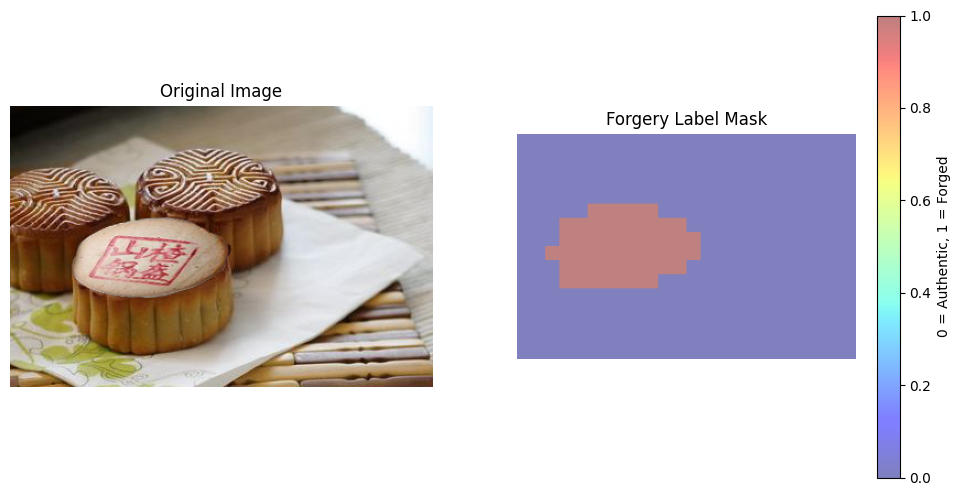

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2ycbcr

# Ensure 3 channels in case of grayscale or alpha channel
def ensure_three_channels(patch):
    if patch.ndim == 2:
        patch = np.stack([patch]*3, axis=-1)  # Convert grayscale to 3-channel
    if patch.shape[-1] == 4:
        patch = patch[..., :3]  # Drop alpha channel if exists
    return patch

def extract_patches_and_labels(image, mask=None, patch_size=32, stride=16, forged_threshold=0.1):
    """
    Extract patches from the image and assign labels based on the mask.
    """
    patches = []
    labels = []
    H, W = image.shape[:2]
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patch_img = image[y:y+patch_size, x:x+patch_size]
            patch_img = ensure_three_channels(patch_img)
            if mask is not None:
                patch_mask = mask[y:y+patch_size, x:x+patch_size]
                forged_frac = np.mean(patch_mask)
                label = 1 if forged_frac >= forged_threshold else 0
            else:
                label = 0  # All authentic if no mask
            patches.append(patch_img)
            labels.append(label)
    return patches, labels

# Load the image and mask (for testing)
tp_path = '/content/gdrive/My Drive/CASIA2_with_mask/CASIA2/Tp'
mask_path = '/content/gdrive/MyDrive/CASIA2_with_mask/CASIA2/CASIA 2 Groundtruth'
image_path = '/content/gdrive/My Drive/CASIA2_with_mask/CASIA2/Tp/Tp_D_CND_M_N_art00076_art00077_10289.tif'  # Replace with the actual path
mask_path = '/content/gdrive/MyDrive/CASIA2_with_mask/CASIA2/CASIA 2 Groundtruth/Tp_D_CND_M_N_art00076_art00077_10289_gt.png'  # Replace with the actual mask path (same name as image, with _gt suffix)

# Load the image and mask
image = imread(image_path)
mask = imread(mask_path)

# Normalize image to [0,1]
image = image.astype(np.float32) / 255.0

# Convert mask to binary if necessary
if mask.ndim == 3:
    mask = mask[..., 0] > 128  # If it's RGB, convert to binary
else:
    mask = mask > 128

# Extract patches and labels
patches, labels = extract_patches_and_labels(image, mask=mask, patch_size=32, stride=16, forged_threshold=0.1)

# Reconstruct the image-like representation of patch labels
H, W = image.shape[:2]
label_image = np.zeros((H, W), dtype=np.uint8)

patch_idx = 0
for y in range(0, H - 32 + 1, 16):
    for x in range(0, W - 32 + 1, 16):
        label_image[y:y+32, x:x+32] = labels[patch_idx]  # Assign label (0 or 1) to the region
        patch_idx += 1

# Display the original image and the mask with labels
plt.figure(figsize=(12,6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Label Mask
plt.subplot(1, 2, 2)
plt.imshow(label_image, cmap='jet', alpha=0.5)
plt.title('Forgery Label Mask')
plt.colorbar(label="0 = Authentic, 1 = Forged")
plt.axis('off')

plt.show()


In [ ]:
from sklearn.utils import resample

# Example of oversampling forged patches
X_forged = X_train[Y_train[:, 1] == 1]  # Select forged patches
Y_forged = Y_train[Y_train[:, 1] == 1]

# Oversample forged patches (with replacement)
X_forged_oversampled, Y_forged_oversampled = resample(X_forged, Y_forged,
                                                     replace=True,    # Sample with replacement
                                                     n_samples=len(X_train) // 2,  # Make it half the total dataset size
                                                     random_state=42)

# Combine oversampled forged patches with original data
X_train_balanced = np.concatenate((X_train, X_forged_oversampled), axis=0)
Y_train_balanced = np.concatenate((Y_train, Y_forged_oversampled), axis=0)

# Shuffle the balanced dataset
X_train_balanced, Y_train_balanced = shuffle(X_train_balanced, Y_train_balanced, random_state=42)